# Cell tower optimization
_2020.06.01_

This notebook prepares the data input files for the cell tower optimization project.

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import json
import requests

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from random import sample, random, randint, getrandbits

tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/zol/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/home/zol/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



- Go to [OpenCellId](https://opencellid.org/#zoom=16&lat=37.77889&lon=-122.41942),
- Register (user: rhema303@gvnuclear.com password: 2e44d4e2bfab75)
- Download the complete dataset from here: https://unwiredlabs.com/dashboard?ref=opencellid#downloads
- Uncompress and copy the csv to the data subfolder
    - [OpenCellId CSV description](http://wiki.opencellid.org/wiki/Menu_map_view#database)
- Edit the settings below
    - Look up the mobile country code here: https://en.wikipedia.org/wiki/Mobile_country_code

In [2]:
country = 'Slovakia' # name of the country
cell_tower_filename = 'data/cell_towers_2020-05-23-T000000.csv' # the path to the downloaded cell tower CSV
cell_tower_rows_limit = 10_000_000 # number of cell records to be read from the cell tower CSV
mobile_country_code = 231 # Mobile country code
user_count = 10_000 # Number of users to be generated
operator_dict = {
    1: 'Orange Slovensko',
    2: 'Slovak Telekom',
    3: 'SWAN Mobile',
    6: 'O2'
}

# Set it to the center of the country
country_center_lat = 48.75
country_center_lon = 19.73

total_population = 3_000_000 # Set this to increase/decrease the rate of people living in the countryside

radius_city = 0.2 # The spread of the location of the people living in city
radius_country = 1.5 # The spread of the location of the people living in the countryside

date_start = '2020-05-01' # Start date of record generation 
date_end = '2020-05-01' # End date of records generation

OPENCAGEDATA_API_KEY = 'e9990b0d6afa4438a14995b657fd502e' # OpenCageData API key for city to geolocation conversion

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print('Memory usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

    return df

## Cell towers generator

**Columns**
- cell_id: unique ID
- radio: technology
- mcc: mobile country code
- net: mobile network code https://www.mcc-mnc.com/
- lat/lon: geolocation
- range: strength of the tower

In [4]:
pdf_tower = pd.read_csv(cell_tower_filename, nrows=cell_tower_rows_limit)
pdf_tower = pdf_tower[pdf_tower['mcc'] == mobile_country_code].copy()
pdf_tower = pdf_tower[['radio', 'net', 'area', 'cell', 'lat', 'lon', 'range']].copy()

pdf_tower = reduce_mem_usage(pdf_tower)
print('Loaded {:,} records and {:} features.'.format(
    pdf_tower.shape[0],
    pdf_tower.shape[1]
))

Memory usage decreased to  1.11 MB (29.7% reduction)
Loaded 25,817 records and 7 features.


In [5]:
pdf_tower.rename(columns={'radio': 'technology', 'net': 'operator_name'}, inplace=True)

In [6]:
pdf_tower.replace({
    "operator_name": operator_dict
}, inplace=True)

In [7]:
pdf_tower['operator_name'].value_counts(sort=False)

O2                   6114
Orange Slovensko    10721
SWAN Mobile           283
Slovak Telekom       8699
Name: operator_name, dtype: int64

In [8]:
pdf_tower['range'].describe()

count     25817.000000
mean       4909.998799
std        8383.029211
min         500.000000
25%        1000.000000
50%        1935.000000
75%        5732.000000
max      314322.000000
Name: range, dtype: float64

In [9]:
def unique_id():
    seed = getrandbits(16)
    while True:
        yield seed
        seed += 1

unique_sequence = unique_id()

uids = []
for i in range(len(pdf_tower)):
    uids.append(hex(next(unique_sequence))[2:])

In [10]:
pdf_tower['cell_id'] = uids

In [11]:
pdf_tower[['cell_id', 'operator_name', 'technology', 'lat', 'lon', 'range']][:5]

cell_id     operator_name technology        lat        lon  range
291393    78ea  Orange Slovensko        GSM  48.095963  17.122099  13223
291394    78eb  Orange Slovensko        GSM  48.085608  17.108707   5805
291395    78ec  Orange Slovensko        GSM  48.108076  17.095604   3934
291396    78ed  Orange Slovensko        GSM  48.099289  17.103798   3802
291397    78ee  Orange Slovensko        GSM  48.140072  17.075835   4876

In [12]:
pdf_tower[['cell_id', 'operator_name', 'technology', 'lat', 'lon', 'range']].to_csv('data/{:}_cell_towers.csv'.format(country.lower()), index=False)
print('`data/{:}_cell_towers.csv` written'.format(country.lower()))

`data/slovakia_cell_towers.csv` written


**Output format**
- 0: cell_id
- 1: operator_id
- 2: technology
- 3: lat
- 4: lon
- 5: strength

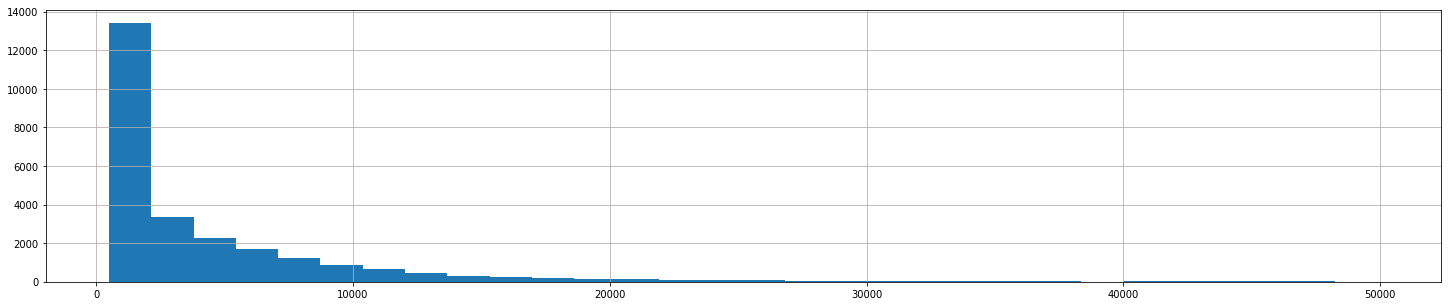

In [13]:
fig = plt.figure(figsize = (25, 5))
ax = fig.gca()

pdf_tower[pdf_tower['range'] < 50000]['range'].hist(ax=ax, bins=30)

In [14]:
with open('html/public/json/{:}.json'.format(country.lower()), 'w') as output:
    output.write('var data = [')
    for i in tqdm(range(len(pdf_tower))):
        output.write("['{:}', '{:}', '{:}', {:}, {:}, {:.0f}], ".format(
            pdf_tower.iloc[i]['cell_id'],
            pdf_tower.iloc[i]['operator_name'],
            pdf_tower.iloc[i]['technology'],
            pdf_tower.iloc[i]['lat'],
            pdf_tower.iloc[i]['lon'],
            pdf_tower.iloc[i]['range']
        ))
    output.write(']')

print('`html/public/json/{:}.json` written'.format(country.lower()))

100%|██████████| 25817/25817 [00:31<00:00, 814.00it/s]

`html/public/json/slovakia.json` written


In [15]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_tower['lat'].values,
        lon=pdf_tower['lon'].values,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

Go to `html` subfolder and edit `index.html` according to the list below:

- _Line 8_: `<title>Cell towers of Slovakia</title>` - change the name of country to the selected
- _Line 88_: `.setView([48.7575287, 19.7304966], 8)` - change the value of the location to the center of the selected country
- _Line 89_: `.setMaxBounds([[49.7, 16.7], [47.7, 22.6]]);` - change the values of the bounding box to incorporate the country

Save the file, then double click it to view the result in the browser.

<figure class="image">
  <img src='images/map_1.png' description='On country level, the cell towers are merged'>
  <figcaption><center>Merged cell towers on country level</center></figcaption>
</figure>

<figure class="image">
  <img src='images/map_2.png' description='The cell towers are clickable'>
  <figcaption><center>Click the cell towers for the info popup</center></figcaption>
</figure>

<figure class="image">
  <img src='images/map_3.png' description='The cell towers can be toggled with button'>
  <figcaption><center>Toggle the cell towers by clicking the technology selector button in the top right corner</center></figcaption>
</figure>

## User table and CDR generator
Downloading the major cities of Slovakia to be the focal points of the user generation. This snippet might needs alteration for a country other than Slovakia.

In [16]:
pdf_big_cities = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Slovakia')[0]
pdf_big_cities = pdf_big_cities[['City or town', 'Population 2018']].copy()
pdf_big_cities.rename(columns={'City or town': 'city', 'Population 2018': 'population'}, inplace=True)
pdf_big_cities.sort_values(by='population', ascending=False, inplace=True)

In [17]:
def get_geolocation(city):
    output = 'Unknown'
    response = requests.get('https://api.opencagedata.com/geocode/v1/json?q={:}&key={:}'.format(
        city,
        OPENCAGEDATA_API_KEY
    ))

    if response.status_code == 200:
        json_string = json.loads(response.content)
        output = json_string['results'][0]['geometry']['lat'], json_string['results'][0]['geometry']['lng']
    else:
        print('Response status: '.format(
            response.status_code
        ))

    return output

pdf_big_cities['latlon'] = pdf_big_cities.progress_apply(lambda x: get_geolocation(x['city']), axis=1)

100%|██████████| 141/141 [01:02<00:00,  2.22it/s]


In [18]:
def parse_list(list_string, index):
    return float(list_string[index])

pdf_big_cities['lat'] = pdf_big_cities.apply(lambda x: parse_list(x['latlon'], 0), axis=1)
pdf_big_cities['lon'] = pdf_big_cities.apply(lambda x: parse_list(x['latlon'], 1), axis=1)

In [19]:
pdf_big_cities[['city', 'population', 'lat', 'lon']][:5]

city  population        lat        lon
0       Bratislava      432864  48.151699  17.109306
1           Košice      238757  48.717227  21.249677
2           Prešov       88680  48.995942  21.246279
3           Žilina       82954  49.223467  18.739314
4  Banská Bystrica       78327  48.738926  19.161761

In [20]:
pdf_big_cities[['city', 'population', 'lat', 'lon']].to_csv('data/{:}_cities.csv'.format(country.lower()), index=False)

### Generate users
Creation of the user table

In [21]:
def random_point_around(lat, lon, distance):
    t = np.random.normal(0.0, 2.0*np.pi)
    r = distance * np.sqrt(abs(np.random.normal(0.1, 1.0)))
    x = lat + r * np.cos(t)
    y = lon + r * np.sin(t)

    return x, y

In [22]:
pdf_big_cities = pd.read_csv('data/{:}_cities.csv'.format(country.lower()))

In [23]:
pdf_big_cities = pdf_big_cities.append({
    'city': 'country',
    'population': total_population-pdf_big_cities['population'].sum(),
    'lat': 49.2, # top right corner
    'lon': 18.0
}, ignore_index=True)

In [24]:
pdf_big_cities['rate'] = pdf_big_cities['population']/total_population
pdf_big_cities['rate_cumsum'] = pdf_big_cities['rate'].cumsum()

In [25]:
pdf_big_cities[['city', 'rate', 'rate_cumsum', 'lat', 'lon']][-5:]

city      rate  rate_cumsum        lat        lon
137    Rajecké Teplice  0.001006     0.970940  49.124287  18.728112
138  Spišská Stará Ves  0.000747     0.971687  49.379999  20.353870
139        Modrý Kameň  0.000540     0.972227  48.240922  19.334171
140            Dudince  0.000474     0.972701  48.168409  18.879731
141            country  0.027299     1.000000  49.200000  18.000000

In [26]:
pdf_users = pd.DataFrame(columns=['city', 'lat', 'lon'])

for i in tqdm(range(user_count)):
    random_rate = random()
    random_city = pdf_big_cities[
            (random_rate <= pdf_big_cities['rate_cumsum'])
        ]['city'].values[0]

    if random_city == 'country':
        lat, lon = random_point_around(pdf_big_cities[pdf_big_cities['city'] == random_city]['lat'].values[0], pdf_big_cities[pdf_big_cities['city'] == random_city]['lon'].values[0], radius_country)
    else:
        lat, lon = random_point_around(pdf_big_cities[pdf_big_cities['city'] == random_city]['lat'].values[0], pdf_big_cities[pdf_big_cities['city'] == random_city]['lon'].values[0], radius_city)

    pdf_users = pdf_users.append({
        'city': random_city,
        'lat': lat,
        'lon': lon
    }, ignore_index=True)

100%|██████████| 10000/10000 [00:45<00:00, 219.77it/s]


In [27]:
pdf_users[:5]

city        lat        lon
0  Hurbanovo  47.877859  18.173641
1   Turzovka  49.273116  18.622605
2  Topoľčany  48.693955  17.867641
3  Topoľčany  48.506896  18.051674
4      Modra  49.198073  22.042348

In [28]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_users['lat'].values[:500],
        lon=pdf_users['lon'].values[:500],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

In [29]:
print('Number of users generated: {:,}\nRate of people living in the countryside: {:.2f}%'.format(
    len(pdf_users),
    len(pdf_users[pdf_users['city'] == 'country'])/len(pdf_users)*100
))

Number of users generated: 10,000
Rate of people living in the countryside: 2.69%


In [30]:
pdf_users['msisdn'] = sample(range(1_000_000, 9_999_999), user_count)

In [31]:
pdf_users[:5]

city        lat        lon   msisdn
0  Hurbanovo  47.877859  18.173641  9165166
1   Turzovka  49.273116  18.622605  7003272
2  Topoľčany  48.693955  17.867641  5380890
3  Topoľčany  48.506896  18.051674  3076516
4      Modra  49.198073  22.042348  5806266

In [32]:
pdf_users['city'].value_counts()[:5]

Bratislava    1427
Košice         807
Prešov         303
Žilina         283
country        269
Name: city, dtype: int64

### CDR records generation

#### Distribution tester
Use this chunk of code to create distributions to better fit the needs

In [33]:
pdf_a = pd.DataFrame(columns=['value'])

for i in range(1000):
    pdf_a = pdf_a.append({
        'value': int(abs(np.random.normal(loc=45, scale=200)))
    }, ignore_index=True)

fig = px.histogram(pdf_a, x="value")
fig.show()

#### Record generator

In [34]:
def random_date(start, end):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    offset = np.random.uniform(0., delta)
    offset = pd.offsets.Second(int(offset))
    t = start + offset
    return t

def random_dates(start, end, pick=10, total=100):
    a = []
    for i in range(total):
        a.append(random_date(start, end))
    
    return sample(a, pick)

In [35]:
pdf_cdr = pd.DataFrame(columns=['msisdn', 'datetime', 'lat', 'lon', 'duration', 'category'])
for date in pd.date_range(start=date_start, end=date_end):
    print(date.strftime('%Y-%m-%d'))
    for user_id in tqdm(range(user_count)):
        call_count = int(abs(np.random.normal(loc=1))*5)
        random_times = random_dates(str(date)[:10] + ' 00:00', str(date)[:10] + ' 23:45', call_count)
        for call_datetime in random_times:
            rnd_lat, rnd_lon = random_point_around(pdf_users.iloc[user_id]['lat'], pdf_users.iloc[user_id]['lon'], 0.01)
            pdf_cdr = pdf_cdr.append({
                'msisdn': pdf_users.iloc[user_id]['msisdn'],
                'datetime': call_datetime,
                'lat': rnd_lat,
                'lon': rnd_lon,
                'duration': int(abs(np.random.normal(loc=45, scale=200))),
                'category': randint(1, 5)
            }, ignore_index=True)    

  0%|          | 3/10000 [00:00<07:58, 20.88it/s]

2020-05-01


100%|██████████| 10000/10000 [07:19<00:00, 22.73it/s]


CDR table
- MSISDN: the ID of the user (aka phone number)
- datetime: the datetime of the call
- lat/lon: geolocation of the starting point of the call
- duration: the duration of the call in seconds
- category: price category of the call

In [36]:
pdf_cdr[:5]

msisdn            datetime        lat        lon duration category
0  9165166 2020-05-01 02:08:55  47.868450  18.170804       55        3
1  7003272 2020-05-01 20:52:17  49.267800  18.623559      239        2
2  7003272 2020-05-01 02:20:13  49.265358  18.617993      118        5
3  7003272 2020-05-01 07:04:31  49.271066  18.620635      278        3
4  7003272 2020-05-01 11:13:34  49.271920  18.627785      114        5

In [37]:
pdf_cdr.to_csv('data/{:}_cdr_{:}_{:}.csv'.format(
    country.lower(),
    date_start,
    date_end
), index=False)

In [38]:
pdf_cdr = reduce_mem_usage(pdf_cdr)
print('CDR records generated: {:,}'.format(
    len(pdf_cdr)
))

Memory usage decreased to  2.41 MB (0.0% reduction)
CDR records generated: 52,705


Showing the first 500 CDRs on map

In [39]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_cdr['lat'].values[:500],
        lon=pdf_cdr['lon'].values[:500],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

## Technical scores of towers

Metrics used:
- downlink
- packet loss

In [40]:
pdf_tower = pd.read_csv('data/{:}_cell_towers.csv'.format(
    country.lower()
))

pdf_tower = reduce_mem_usage(pdf_tower)
print('Cell tower set contains: {:,} records with {:} features'.format(
    pdf_tower.shape[0],
    pdf_tower.shape[1]
))

Memory usage decreased to  1.08 MB (8.3% reduction)
Cell tower set contains: 25,817 records with 6 features


In [41]:
pdf_cdr = pd.read_csv('data/{:}_cdr_{:}_{:}.csv'.format(
    country.lower(),
    date_start,
    date_end
), parse_dates=['datetime'])

pdf_cdr = reduce_mem_usage(pdf_cdr)
print('CDR set contains: {:,} records with {:} features'.format(
    pdf_cdr.shape[0],
    pdf_cdr.shape[1]
))

Memory usage decreased to  1.56 MB (35.4% reduction)
CDR set contains: 52,705 records with 6 features


In [42]:
pdf_tower['technology'].unique()

array(['GSM', 'UMTS', 'LTE'], dtype=object)

In [43]:
technology_metrics = {
    'GSM': {
        'downlink': 384, # kbps
        'packet_loss_range': [0.3, 0.85]
    },
    'UMTS': {
        'downlink': 42_000, # 42 Mbps
        'packet_loss_range': [0.25, 0.8]
    },
    'LTE': {
        'downlink': 3_000_000, # 3 Gbps
        'packet_loss_range': [0.1, 0.7]
    }
}

### Counting users in range

In [44]:
def count_users_in_range(lat, lon, threshold_lat=0.01, threshold_lon=0.01):
    return len(pdf_cdr[
        (lat - threshold_lat <= pdf_cdr['lat']) &
        (pdf_cdr['lat'] <= lat + threshold_lat) &
        (lon - threshold_lon <= pdf_cdr['lon']) &
        (pdf_cdr['lon'] <= lon + threshold_lon)
    ])
    
pdf_tower['users_in_range'] = pdf_tower.progress_apply(lambda x: count_users_in_range(x['lat'], x['lon']), axis=1)

100%|██████████| 25817/25817 [01:25<00:00, 301.09it/s]


In [45]:
pdf_tower[['cell_id', 'technology', 'operator_name', 'lat', 'lon', 'range', 'users_in_range']][:5]

cell_id technology     operator_name        lat        lon  range  \
0    78ea        GSM  Orange Slovensko  48.095963  17.122099  13223   
1    78eb        GSM  Orange Slovensko  48.085608  17.108707   5805   
2    78ec        GSM  Orange Slovensko  48.108076  17.095604   3934   
3    78ed        GSM  Orange Slovensko  48.099289  17.103798   3802   
4    78ee        GSM  Orange Slovensko  48.140072  17.075835   4876   

   users_in_range  
0              51  
1              16  
2              16  
3              11  
4              15

In [46]:
print('Rate of cell towers with no user in range: {:.2f}%'.format(
    len(pdf_tower[pdf_tower['users_in_range'] == 0]['users_in_range'])/len(pdf_tower['users_in_range'])*100
))

Rate of cell towers with no user in range: 21.46%


In [47]:
pdf_tower['users_in_range'].value_counts(sort=True)[:5]

0    5541
1    2550
2    2060
3    1852
4    1415
Name: users_in_range, dtype: int64

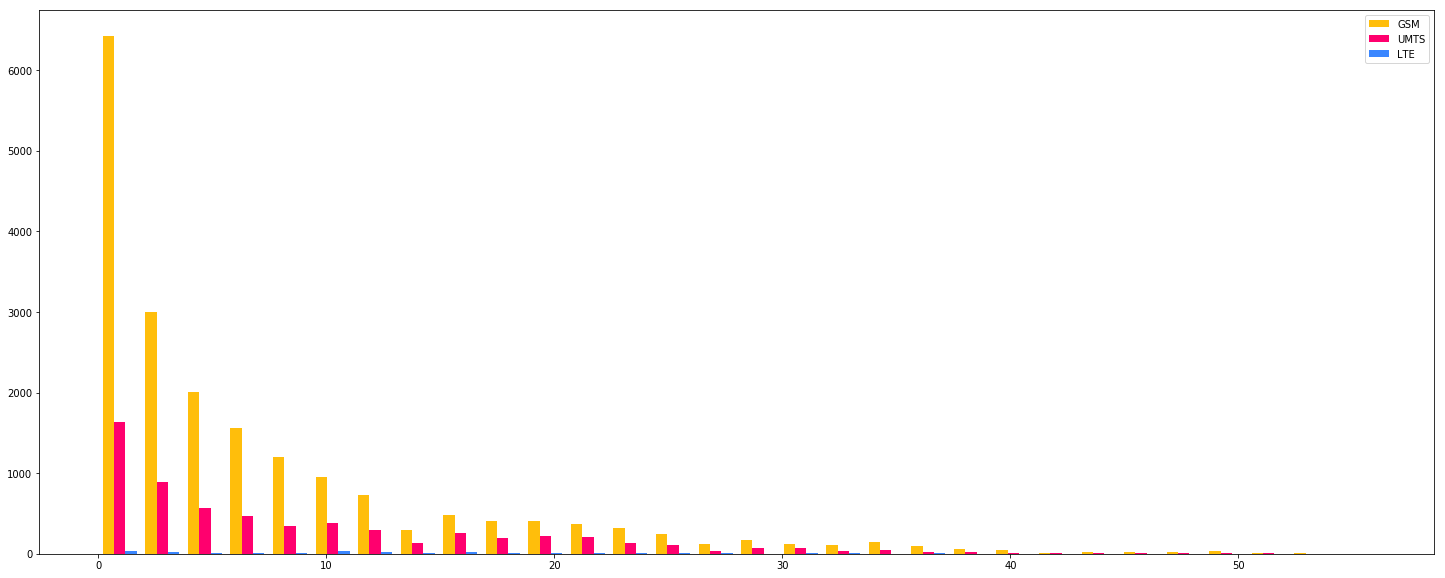

In [48]:
plt.style.use('seaborn-deep')
fig = plt.figure(figsize = (25, 10))
ax = fig.gca()

plt.hist([
    pdf_tower[pdf_tower['technology'] == 'GSM']['users_in_range'],
    pdf_tower[pdf_tower['technology'] == 'UMTS']['users_in_range'],
    pdf_tower[pdf_tower['technology'] == 'LTE']['users_in_range']
], bins=30, label=['GSM', 'UMTS', 'LTE'], color=['#ffbe0b', '#ff006e', '#3a86ff'], stacked=False)
plt.legend(loc='upper right')
plt.show()

### Functions

In [49]:
def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def generate_clamped_normal_value(minimum, maximum):
    return clamp(minimum, (maximum + minimum)/2 + (maximum - minimum)*np.random.normal(loc=0, scale=0.15), maximum)

def generate_tower_statistics(cell_id):
    cell_index = pdf_tower[pdf_tower['cell_id'] == cell_id].index
    cell_technology = pdf_tower.loc[cell_index, 'technology'].values[0]

    downlink = int(generate_clamped_normal_value(
        0,
        technology_metrics[cell_technology]['downlink']
    ))

    packet_loss = round(generate_clamped_normal_value(
        technology_metrics[cell_technology]['packet_loss_range'][0],
        technology_metrics[cell_technology]['packet_loss_range'][1]
    ), 2)

    # the number of users of the cell is correlated with the downlink and less packet loss
    return downlink, packet_loss

### Testing

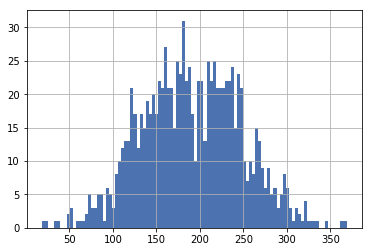

In [50]:
pdf_tmp = pd.DataFrame(columns={'value'})
for i in range(1000):
    pdf_tmp = pdf_tmp.append({
        'value': generate_clamped_normal_value(0, technology_metrics['GSM']['downlink'])
    }, ignore_index=True)

pdf_tmp['value'].hist(bins=100)

In [51]:
generate_tower_statistics(pdf_tower.iloc[0]['cell_id'])

(204, 0.61)

### Data generation

In [52]:
pdf_tower['downlink'],  pdf_tower['packet_loss'] = zip(*pdf_tower.progress_apply(lambda x: generate_tower_statistics(x['cell_id']), axis=1))

100%|██████████| 25817/25817 [01:18<00:00, 327.70it/s]


In [53]:
pdf_tower[:5]

cell_id     operator_name technology        lat        lon  range  \
0    78ea  Orange Slovensko        GSM  48.095963  17.122099  13223   
1    78eb  Orange Slovensko        GSM  48.085608  17.108707   5805   
2    78ec  Orange Slovensko        GSM  48.108076  17.095604   3934   
3    78ed  Orange Slovensko        GSM  48.099289  17.103798   3802   
4    78ee  Orange Slovensko        GSM  48.140072  17.075835   4876   

   users_in_range  downlink  packet_loss  
0              51       112         0.58  
1              16        97         0.41  
2              16       231         0.64  
3              11       183         0.62  
4              15       188         0.57

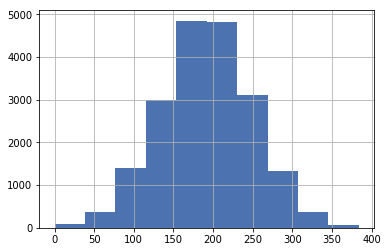

In [54]:
pdf_tower[pdf_tower['technology'] == 'GSM']['downlink'].hist()

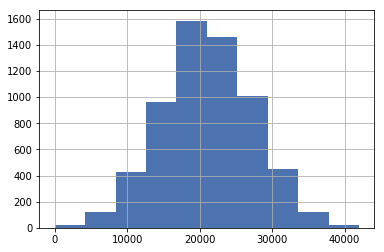

In [55]:
pdf_tower[pdf_tower['technology'] == 'UMTS']['downlink'].hist()

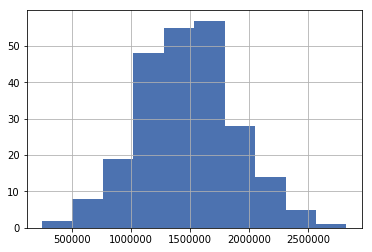

In [56]:
pdf_tower[pdf_tower['technology'] == 'LTE']['downlink'].hist()

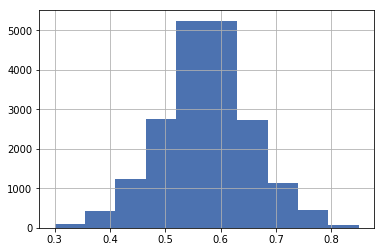

In [57]:
pdf_tower[pdf_tower['technology'] == 'GSM']['packet_loss'].hist()

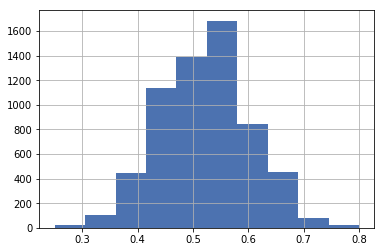

In [58]:
pdf_tower[pdf_tower['technology'] == 'UMTS']['packet_loss'].hist()

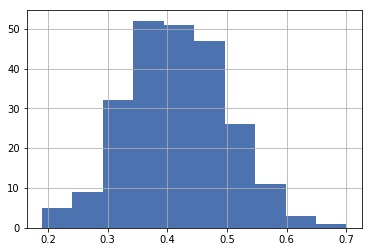

In [59]:
pdf_tower[pdf_tower['technology'] == 'LTE']['packet_loss'].hist()

In [60]:
pdf_tower[:5]

cell_id     operator_name technology        lat        lon  range  \
0    78ea  Orange Slovensko        GSM  48.095963  17.122099  13223   
1    78eb  Orange Slovensko        GSM  48.085608  17.108707   5805   
2    78ec  Orange Slovensko        GSM  48.108076  17.095604   3934   
3    78ed  Orange Slovensko        GSM  48.099289  17.103798   3802   
4    78ee  Orange Slovensko        GSM  48.140072  17.075835   4876   

   users_in_range  downlink  packet_loss  
0              51       112         0.58  
1              16        97         0.41  
2              16       231         0.64  
3              11       183         0.62  
4              15       188         0.57

In [61]:
pdf_tower[['cell_id', 'downlink', 'packet_loss']].to_csv('data/{:}_cell_tower_statistics.csv'.format(country.lower()), index=False)
print('`data/{:}_cell_tower_statistics.csv` written'.format(country.lower()))

`data/slovakia_cell_tower_statistics.csv` written
